In [1]:
import sys,os
import tarfile
import warnings

import numpy as np
import pandas as pd
import xarray as xr

import SDFC.link as sdl
import NSSEA as ns
import NSSEA.plot as nsp
import NSSEA.models as nsm
import scipy.stats as sc
import statsmodels.api as sm

import cProfile
import pstats
from pstats import SortKey


import cftime

import seaborn as sns
import time as tm
import pygam as pg

import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
# dd/mm/YY H:M:S
dt_string = now.strftime("%m%d%H%M")
print( dt_string)

Number of processors:  8
08211349


In [2]:
np.random.seed(int(dt_string))


In [3]:
%run '/home/barbauxo/Documents/Doctorat/03_Travail/2023_01 Application Tricastin/Scripts/data_preparation.py'
%run '/home/barbauxo/Documents/Doctorat/03_Travail/2023_01 Application Tricastin/Scripts/Interest_Quantities.py'

%run "Utils/01Charge_Utils.py"

Number of processors:  8


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
basepath=os.path.abspath(os.getcwd())
pathInp='/home/barbauxo/Documents/Doctorat/03_Travail/2023_01 Application Tricastin/Data'
#pathOut='../Outputs/Outputs (Test Full_V1 Hadcrut)'
pathGCM='/home/barbauxo/Documents/Doctorat/03_Travail/2023_05 Calcul Multimodel/data'
assert(os.path.exists(pathInp))
assert(os.path.exists(pathGCM))

time_period    = np.arange( 1850 , 2101 , 1 , dtype = np.int )
time_reference = np.arange( 1986 , 2016 , 1 , dtype = np.int )
type_data="03_Post_treatment"  #"02_Selected" #"03_Post_treatment" #But no absolute temp

ci          = 0.05
sample_dis=False #If want n sample of each GCM model. For graph only, not used for multisynthesis. Takes a lot of time

#Time period of interest
T=100
T1=2000
T2=2100
deb=1850
fin=2101

#Bayes arg

n_sample    = 100 #N tirage X
min_rate_accept = 0.05
burn_in=1000
n_val_MCMC=100

n_mcmc_drawn_min=  5000 
n_mcmc_drawn_max= 10000 


## Some global parameters
##=======================

#bayes_kwargs = { "n_mcmc_drawn_min" :  5000 , "n_mcmc_drawn_max" : 10000 }
 
ns_law      = nsm.GEV()
event       = ns.Event( "HW19" , 2019 , time_reference , type_ = "value" , variable = "TX3X" , unit = "K" )
verbose     = "--not-verbose" not in sys.argv

In [6]:
lX,lY,models=load_models_CMIP6(pathInp,type_data)
Xo,Yo=load_obs(pathInp,type_data)
event.value = float(Yo.loc[event.time])

['ACCESS-CM2_i1p1f1', 'ACCESS-ESM1-5_i1p1f1', 'CMCC-ESM2_i1p1f1', 'CNRM-CM6-1-HR_i1p1f2', 'CNRM-CM6-1_i1p1f2', 'CNRM-ESM2-1_i1p1f2', 'CanESM5_i1p2f1', 'EC-Earth3-CC_i1p1f1', 'EC-Earth3-Veg-LR_i1p1f1', 'EC-Earth3-Veg_i1p1f1', 'EC-Earth3_i1p1f1', 'FGOALS-g3_i1p1f1', 'GFDL-ESM4_i1p1f1', 'HadGEM3-GC31-LL_i1p1f3', 'HadGEM3-GC31-MM_i1p1f3', 'INM-CM4-8_i1p1f1', 'INM-CM5-0_i1p1f1', 'IPSL-CM6A-LR_i1p1f1', 'KACE-1-0-G_i1p1f1', 'MIROC-ES2L_i1p1f2', 'MIROC6_i1p1f1', 'MPI-ESM1-2-LR_i1p1f1', 'MRI-ESM2-0_i1p1f1', 'MRI-ESM2-0_i2p1f1', 'NESM3_i1p1f1', 'NorESM2-MM_i1p1f1', 'TaiESM1_i1p1f1', 'UKESM1-0-LL_i1p1f2']


In [7]:
## Define clim variable from input
##================================
clim = ns.Climatology( event , time_period , models ,n_sample  , ns_law )
Xebm   = ns.EBM().draw_sample( clim.time , n_sample + 1 , fix_first = 0 )

In [8]:
clim.event.value

4.223333333333336

In [9]:
print(ns.__version__)

0.4.0a11


In [10]:
clim =covariates_FC_GAM_pygam_light( clim , lX ,  Xebm , dof = 7 , verbose = False )
clim = nslaw_fit_light( lY , clim , verbose = verbose ) 
clim = infer_multi_model_light( clim , verbose = verbose )

nslaw_fit                 (100.0%) [##########################################]
infer_multi_model         (100.0%) [##########################################]


In [11]:
## Add constraint on X
clim_light_MM = clim.copy()
clim_light_MM.keep_models( "Multi_Synthesis" )
clim_light_CX     = ns.constrain_covariate( clim_light_MM , Xo , time_reference , verbose = verbose )
clim_light_CX.to_netcdf( os.path.join( pathGCM , ("clim_temp_light_CX"+dt_string+".nc")  ) )

constrain_covariate       (100.0%) [##########################################]


In [12]:
clim=clim_light_CX

In [13]:
n_sample    = 100 #N tirage X
min_rate_accept = 0.05
burn_in=1000
n_val_MCMC=100

n_sortie=100

In [14]:
#Test for adaptative MH


cProfile.run('clim_CXCB_MH=constrain_MCMC_MH_law_all( clim, Yo,TransitionAdapt=True,n_sortie=n_sortie)','restatsMH')
clim_CXCB_MH.to_netcdf( os.path.join( pathGCM , ("clim_temp_light_CXCB_MH"+dt_string+".nc")  ) )
clim_CXCB_MH.law_coef.loc[:,"BE",:]

constrain_law             (99.01%) [######################################### ]


<xarray.DataArray 'law_coef' (coef: 5, model: 1)>
array([[-0.31101515],
       [ 1.34433073],
       [ 0.44370506],
       [ 0.04304646],
       [-0.22040587]])
Coordinates:
  * model        (model) <U15 'Multi_Synthesis'
  * coef         (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'
    sample_MCMC  <U7 'BE'

In [15]:
paramsCXCB_MH = build_params_along_time_fixed( clim_CXCB_MH , verbose = verbose )
paramsCXCB_MH

build_params_along_time   (100.0%) [##########################################]


<xarray.DataArray (time: 251, sample: 10001, forcing: 2, param: 3, model: 1)>
array([[[[[-1.60584078],
          [ 1.72822356],
          [-0.22755915]],

         [[-1.60584085],
          [ 1.72822355],
          [-0.22755915]]],


        [[[-2.21916386],
          [ 1.36521858],
          [-0.19187713]],

         [[-2.21916379],
          [ 1.36521858],
          [-0.19187713]]],


        [[[-1.96115747],
          [ 1.48957284],
...
          [ 1.5609091 ],
          [-0.15247225]]],


        [[[ 5.91706535],
          [ 2.63539096],
          [-0.21921255]],

         [[-2.01220225],
          [ 1.24854265],
          [-0.21921255]]],


        [[[ 7.97102766],
          [ 2.03175954],
          [-0.22040587]],

         [[-1.80335107],
          [ 1.4857495 ],
          [-0.22040587]]]]])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * sample   (sample) <U7 'S000_0' 'S001_0' 'S002_0' ... 'S099_99' 'BE'
  * forcing  (forcing) <U1 'F' 'C'
  * param    (param) <U5 'loc' 'scale' 'shape'
  * model    (model) <U15 'Multi_Synthesis'

In [16]:

p = pstats.Stats('restatsMH')
p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

Fri Aug 18 17:06:51 2023    restatsMH

         270684970 function calls (261500685 primitive calls) in 1058.243 seconds

   Ordered by: cumulative time
   List reduced from 1185 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000 1058.248 1058.248 {built-in method builtins.exec}
        1    0.000    0.000 1058.248 1058.248 <string>:1(<module>)
        1    0.009    0.009 1058.247 1058.247 /home/barbauxo/Documents/Packages/MCMC_Variants/Utils/NSSEA_Deroule.py:265(constrain_MCMC_MH_law_all)
      100    0.002    0.000 1054.580   10.546 /home/barbauxo/Documents/Packages/MCMC_Variants/Utils/NSSEA_Deroule.py:259(draw_MCMC_MH)
      100   20.864    0.209 1054.578   10.546 /home/barbauxo/Documents/Packages/MCMC_Variants/Utils/NSSEA_Deroule.py:210(MCMC_MH_Stop_ESS)
21664132/13260670   96.992    0.000  578.689    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   670800   15.540    0.0

In [17]:
p = pstats.Stats('restatsMH')
p.sort_stats(SortKey.TIME).print_stats(10)

Fri Aug 18 17:06:51 2023    restatsMH

         270684970 function calls (261500685 primitive calls) in 1058.243 seconds

   Ordered by: internal time
   List reduced from 1185 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 10228252  152.690    0.000  152.690    0.000 {method 'reduce' of 'numpy.ufunc' objects}
21664132/13260670   96.992    0.000  578.689    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   570900   58.457    0.000  256.209    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/numpy/lib/function_base.py:2486(cov)
   670800   50.673    0.000  201.581    0.000 {method 'multivariate_normal' of 'numpy.random._generator.Generator' objects}
   673534   45.133    0.000  248.813    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/SDFC-0.6.0.post1-py3.8-linux-x86_64.egg/SDFC/__GEV.py:292(_negloglikelihood)
   671252   38.280    0.000   50.070    0.000

In [18]:
#Tetst for adaptative MHWG
cProfile.run('clim_CXCB_MHWG=constrain_MCMC_MHWG_law_all( clim, Yo,TransitionAdapt=True,n_sortie=n_sortie)','restatsMHWG')
clim_CXCB_MHWG.to_netcdf( os.path.join( pathGCM , ("clim_temp_light_CXCB_MHWG"+dt_string+".nc")  ) )
clim_CXCB_MHWG.law_coef.loc[:,"BE",:]

constrain_law             (99.01%) [######################################### ]


<xarray.DataArray 'law_coef' (coef: 5, model: 1)>
array([[-0.30706534],
       [ 1.33566935],
       [ 0.44383337],
       [ 0.04275048],
       [-0.21933927]])
Coordinates:
  * model        (model) <U15 'Multi_Synthesis'
  * coef         (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'
    sample_MCMC  <U7 'BE'

In [19]:
paramsCXCB_MHWG = build_params_along_time_fixed( clim_CXCB_MHWG , verbose = verbose )
paramsCXCB_MHWG

build_params_along_time   (100.0%) [##########################################]


<xarray.DataArray (time: 251, sample: 10001, forcing: 2, param: 3, model: 1)>
array([[[[[-2.23669026],
          [ 1.37575736],
          [-0.24506298]],

         [[-2.23669034],
          [ 1.37575736],
          [-0.24506298]]],


        [[[-1.90693792],
          [ 1.44278105],
          [-0.21481312]],

         [[-1.90693785],
          [ 1.44278106],
          [-0.21481312]]],


        [[[-1.91903825],
          [ 2.12882472],
...
          [ 1.39028318],
          [-0.24313024]]],


        [[[ 5.83385506],
          [ 1.8325867 ],
          [-0.16632151]],

         [[-1.85954049],
          [ 1.34449548],
          [-0.16632151]]],


        [[[ 7.92161717],
          [ 2.0283183 ],
          [-0.21933927]],

         [[-1.7897863 ],
          [ 1.48642848],
          [-0.21933927]]]]])
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * sample   (sample) <U7 'S000_0' 'S001_0' 'S002_0' ... 'S099_99' 'BE'
  * forcing  (forcing) <U1 'F' 'C'
  * param    (param) <U5 'loc' 'scale' 'shape'
  * model    (model) <U15 'Multi_Synthesis'

In [20]:
p = pstats.Stats('restatsMHWG')
p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

Fri Aug 18 17:29:51 2023    restatsMHWG

         448214992 function calls (438827413 primitive calls) in 1155.595 seconds

   Ordered by: cumulative time
   List reduced from 1055 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000 1155.623 1155.623 {built-in method builtins.exec}
        1    0.000    0.000 1155.623 1155.623 <string>:1(<module>)
        1    0.009    0.009 1155.623 1155.623 /home/barbauxo/Documents/Packages/MCMC_Variants/Utils/NSSEA_Deroule.py:371(constrain_MCMC_MHWG_law_all)
      100    0.002    0.000 1151.799   11.518 /home/barbauxo/Documents/Packages/MCMC_Variants/Utils/NSSEA_Deroule.py:365(draw_MCMC_MHWG)
      100   28.001    0.280 1151.797   11.518 /home/barbauxo/Documents/Packages/MCMC_Variants/Utils/NSSEA_Deroule.py:313(MCMC_MHWG_Stop_ESS)
26763099/21866693   64.427    0.000  430.493    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    27195    0.29

In [21]:
p = pstats.Stats('restatsMHWG')
p.sort_stats(SortKey.TIME).print_stats(10)

Fri Aug 18 17:29:51 2023    restatsMHWG

         448214992 function calls (438827413 primitive calls) in 1155.595 seconds

   Ordered by: internal time
   List reduced from 1055 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 17216781  100.856    0.000  100.856    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  1138706   75.095    0.000  396.466    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/SDFC-0.6.0.post1-py3.8-linux-x86_64.egg/SDFC/__GEV.py:292(_negloglikelihood)
26763099/21866693   64.427    0.000  430.493    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  7148330   39.799    0.000  113.151    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/numpy/core/_methods.py:163(_mean)
   772450   33.219    0.000   55.140    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/numpy/core/_methods.py:196(_var)
   135975   32.858    0.00

In [32]:
pathOut='Outputs/'

In [33]:
clim_CXCB_MHWG.law_coef[:,1:,:]

<xarray.DataArray 'law_coef' (coef: 5, sample_MCMC: 10000, model: 1)>
array([[[-0.19125514],
        [-0.49207262],
        [-0.24861636],
        ...,
        [-0.25327943],
        [-0.27653594],
        [-0.30706534]],

       [[ 1.4670158 ],
        [ 1.298092  ],
        [ 1.21738808],
        ...,
        [ 1.44489819],
        [ 1.29819764],
        [ 1.33566935]],

       [[ 0.41662923],
        [ 0.7594361 ],
        [ 0.32884538],
        ...,
        [ 0.36184418],
        [ 0.35974515],
        [ 0.44383337]],

       [[ 0.04280159],
        [ 0.00351689],
        [ 0.09530496],
        ...,
        [ 0.02938452],
        [ 0.05226097],
        [ 0.04275048]],

       [[-0.21481312],
        [-0.23350235],
        [-0.22051246],
        ...,
        [-0.24313024],
        [-0.16632151],
        [-0.21933927]]])
Coordinates:
  * model        (model) <U15 'Multi_Synthesis'
  * coef         (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'
  * sample_MCMC  (sample_MCMC) <U7 'S001_0' 'S002_0' 'S003_0' ... 'S099_99' 'BE'

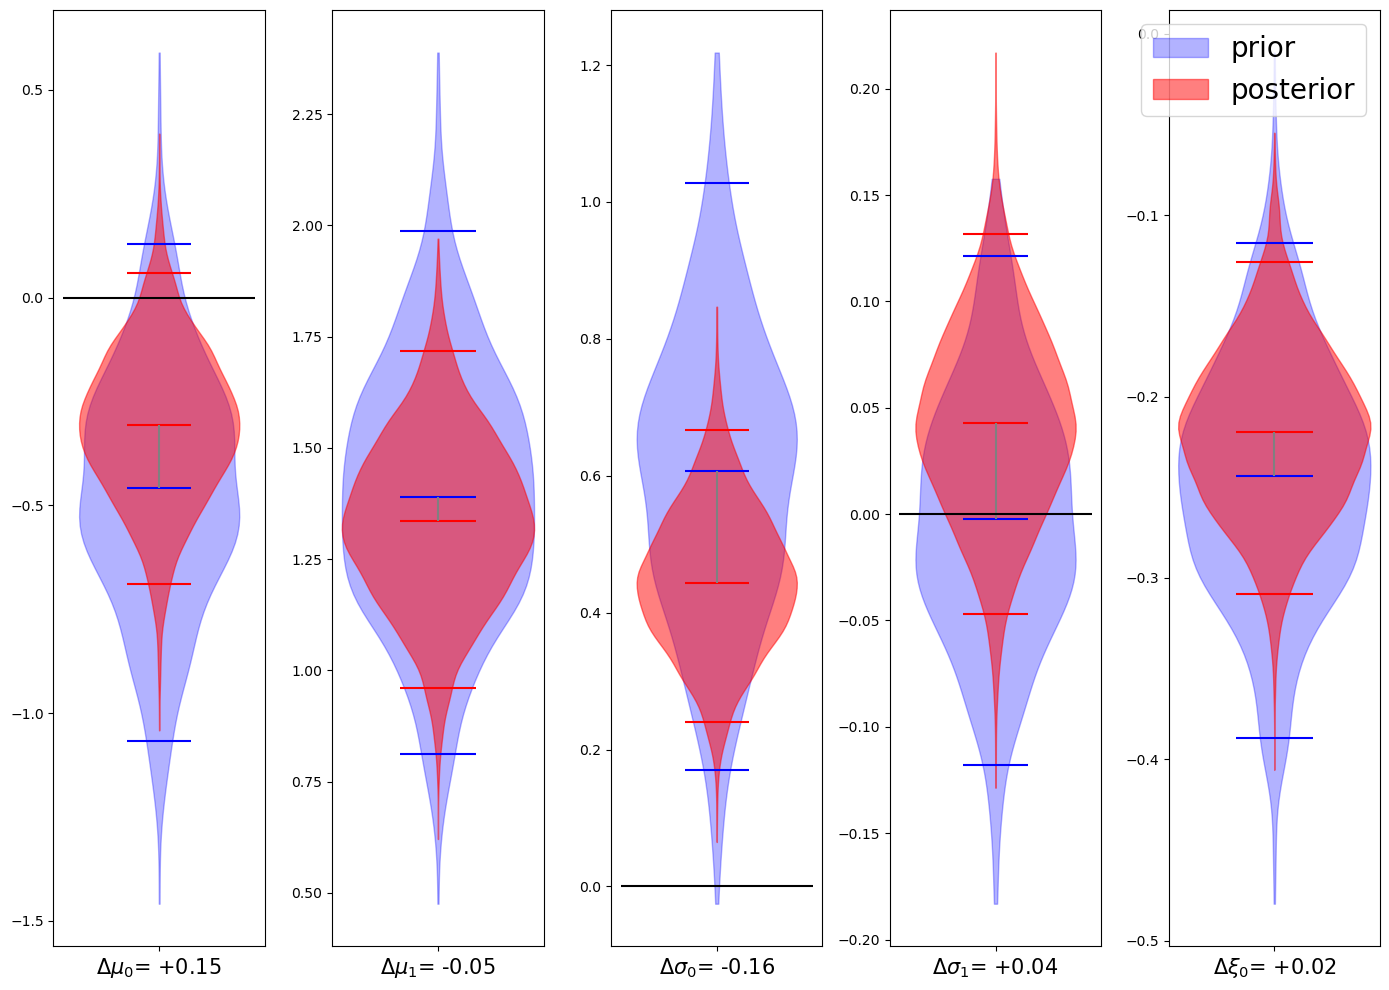

In [34]:
## Quantile

qcoef = clim_light_CX.law_coef[:,1:,:].quantile( [ci/2,1-ci/2,0.5] , dim = "sample" ).assign_coords( quantile = ["ql","qu","BE"] )

qcoefX=clim_CXCB_MHWG.law_coef[:,1:,:].quantile( [ci/2,1-ci/2,0.5] , dim = "sample_MCMC" ).assign_coords( quantile = ["ql","qu","BE"] )
#if not clim.BE_is_median:
# qcoef.loc["BE",:,:] = clim.law_coef.loc[:,"BE",:]
#qcoef.loc[["ql","qu"],:,:] = qcoef.loc[["ql","qu"],:,:]
## mpl parameter


kwargs = {  "showmeans" : False , "showextrema" : False , "showmedians" : False }
#"positions" : range(clim.n_coef) ,
m='Multi_Synthesis'

fig = plt.figure( figsize = ( 14 , 10 ) )

for i in range(clim.n_coef):

    ax = fig.add_subplot(1,5,i+1)

    ## violin plot
    vplot = ax.violinplot( ((clim_light_CX.law_coef) )[:,1:,:].loc[clim.law_coef.coef[i],:,m] , **kwargs )
    vplotc = ax.violinplot( ((clim_CXCB_MHWG.law_coef) )[:,1:,:].loc[clim_CXCB_MHWG.law_coef.coef[i],:,m]  , **kwargs )
    
    for pc in vplotc["bodies"]:
        pc.set_facecolor("red")
        pc.set_edgecolor("red")
        pc.set_alpha(0.5)

    for pc in vplot["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")
        pc.set_alpha(0.3)
    
    ## Change color
    #for pc in vplot["bodies"]:
    #    pc.set_facecolor("red")
    #    pc.set_edgecolor("red")
    #    pc.set_alpha(0.5)

    ## add quantiles

    for q in ["ql","qu","BE"]:
        a=ax.hlines( qcoefX[:,i,:].loc[q,m] , 1 - 0.1 , 1 + 0.1 , color = "red", label= "posterior" )
        ax.hlines( qcoef[:,i,:].loc[q,m] , 1 - 0.1 , 1 + 0.1 , color = "blue",label="prior" )
      
    #ax.hlines( 0 , -0.5 , clim.n_coef-0.5 , color = "black" )

    ax.vlines( 1 , qcoefX[:,i,:].loc["BE",m] , qcoef[:,i,:].loc["BE",m] , color = "grey" )

    ## some params
#ax.set_xlim((-0.5,clim.n_coef-0.5))
    ax.set_xticks([1])
    q=qcoefX[:,i,:].loc["BE",m] - qcoef[:,i,:].loc["BE",m] 
    xticks = [ "$\\Delta${}".format(clim.ns_law.get_params_names(True)[i]) + "= {}".format( "+" if np.sign(q) > 0 else "-" ) + r"${}$".format(float(np.sign(q)) * round(float(q),2)) ]
    ax.set_xticklabels( xticks , fontsize = 15 )
    if ((clim_light_CX.law_coef) )[:,1:,:].loc[clim_light_CX.law_coef.coef[i],:,m].min()*((clim_light_CX.law_coef) )[:,1:,:].loc[clim_light_CX.law_coef.coef[i],:,m].max()<0:
            ax.hlines( 0 , 1-0.3 , 1+0.3, color = "black" )
#for item in ax.get_yticklabels():
        #item.set_fontsize(15)
#ax.set_ylim(ylim)

#ax.set_title( " ".join(m.split("_")) , fontsize = 20 )
ax.legend(["prior","posterior"],fontsize = 20)
fig.set_tight_layout(True)

plt.savefig(os.path.join( pathOut ,"Distribution_parameters_PostBayes.png"))
plt.show()

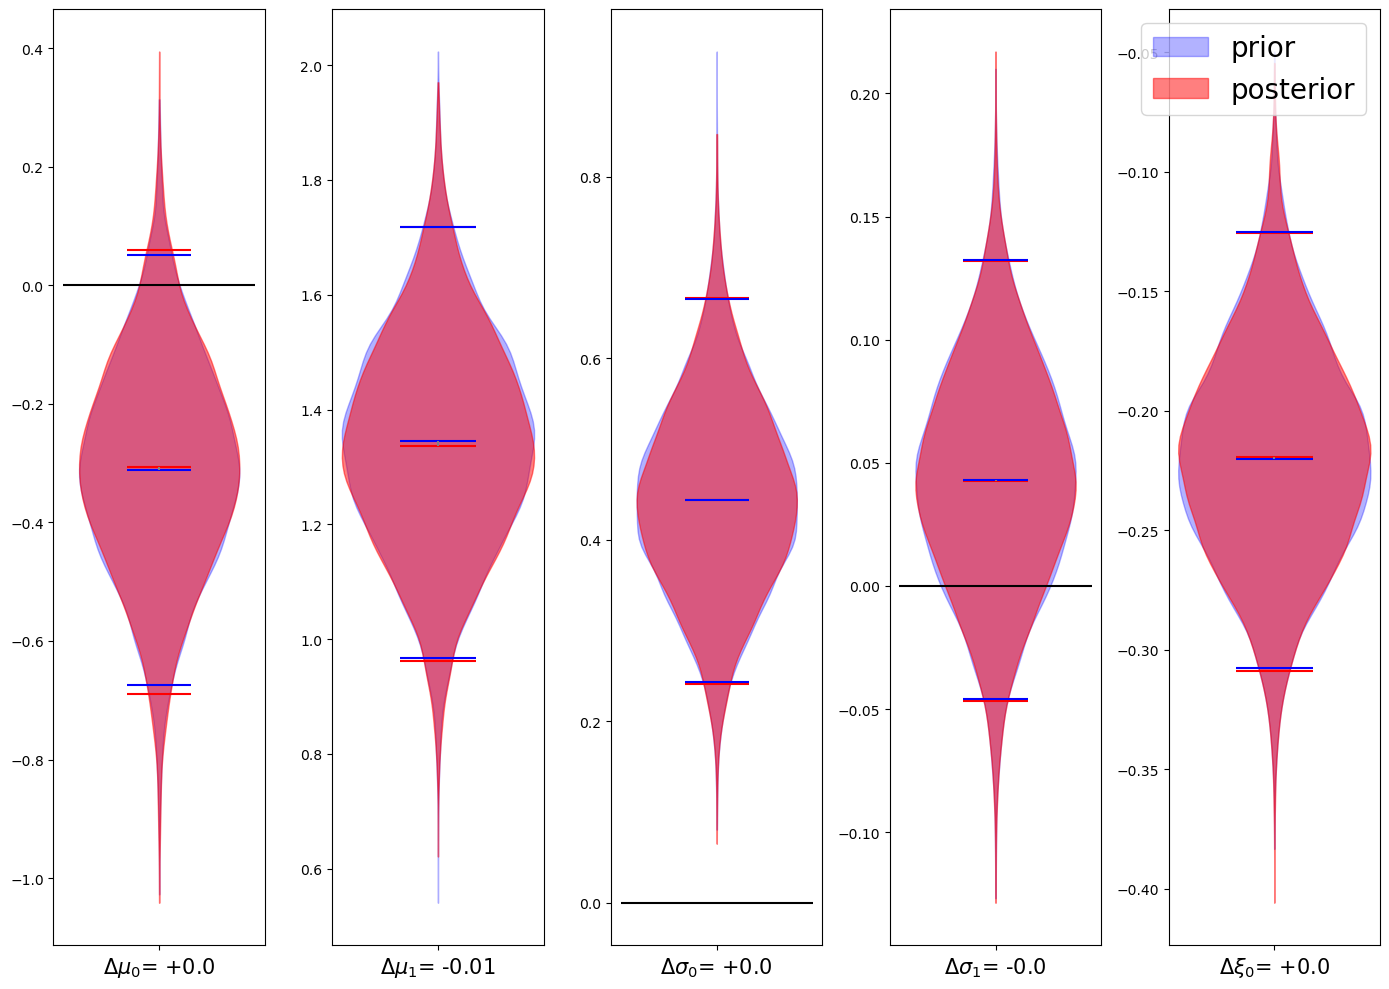

In [35]:
## Quantile

qcoef = clim_CXCB_MH.law_coef[:,1:,:].quantile( [ci/2,1-ci/2,0.5] , dim = "sample_MCMC" ).assign_coords( quantile = ["ql","qu","BE"] )

qcoefX=clim_CXCB_MHWG.law_coef[:,1:,:].quantile( [ci/2,1-ci/2,0.5] , dim = "sample_MCMC" ).assign_coords( quantile = ["ql","qu","BE"] )
#if not clim.BE_is_median:
# qcoef.loc["BE",:,:] = clim.law_coef.loc[:,"BE",:]
#qcoef.loc[["ql","qu"],:,:] = qcoef.loc[["ql","qu"],:,:]
## mpl parameter


kwargs = {  "showmeans" : False , "showextrema" : False , "showmedians" : False }
#"positions" : range(clim.n_coef) ,
m='Multi_Synthesis'

fig = plt.figure( figsize = ( 14 , 10 ) )

for i in range(clim.n_coef):

    ax = fig.add_subplot(1,5,i+1)

    ## violin plot
    vplot = ax.violinplot( ((clim_CXCB_MH.law_coef) )[:,1:,:].loc[clim_CXCB_MH.law_coef.coef[i],:,m] , **kwargs )
    vplotc = ax.violinplot( ((clim_CXCB_MHWG.law_coef) )[:,1:,:].loc[clim_CXCB_MHWG.law_coef.coef[i],:,m]  , **kwargs )
    
    for pc in vplotc["bodies"]:
        pc.set_facecolor("red")
        pc.set_edgecolor("red")
        pc.set_alpha(0.5)

    for pc in vplot["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")
        pc.set_alpha(0.3)
    
    ## Change color
    #for pc in vplot["bodies"]:
    #    pc.set_facecolor("red")
    #    pc.set_edgecolor("red")
    #    pc.set_alpha(0.5)

    ## add quantiles

    for q in ["ql","qu","BE"]:
        a=ax.hlines( qcoefX[:,i,:].loc[q,m] , 1 - 0.1 , 1 + 0.1 , color = "red", label= "posterior" )
        ax.hlines( qcoef[:,i,:].loc[q,m] , 1 - 0.1 , 1 + 0.1 , color = "blue",label="prior" )
      
    #ax.hlines( 0 , -0.5 , clim.n_coef-0.5 , color = "black" )

    ax.vlines( 1 , qcoefX[:,i,:].loc["BE",m] , qcoef[:,i,:].loc["BE",m] , color = "grey" )

    ## some params
#ax.set_xlim((-0.5,clim.n_coef-0.5))
    ax.set_xticks([1])
    q=qcoefX[:,i,:].loc["BE",m] - qcoef[:,i,:].loc["BE",m] 
    xticks = [ "$\\Delta${}".format(clim.ns_law.get_params_names(True)[i]) + "= {}".format( "+" if np.sign(q) > 0 else "-" ) + r"${}$".format(float(np.sign(q)) * round(float(q),2)) ]
    ax.set_xticklabels( xticks , fontsize = 15 )
    if ((clim_light_CX.law_coef) )[:,1:,:].loc[clim_light_CX.law_coef.coef[i],:,m].min()*((clim_light_CX.law_coef) )[:,1:,:].loc[clim_light_CX.law_coef.coef[i],:,m].max()<0:
            ax.hlines( 0 , 1-0.3 , 1+0.3, color = "black" )
#for item in ax.get_yticklabels():
        #item.set_fontsize(15)
#ax.set_ylim(ylim)

#ax.set_title( " ".join(m.split("_")) , fontsize = 20 )
ax.legend(["prior","posterior"],fontsize = 20)
fig.set_tight_layout(True)

plt.savefig(os.path.join( pathOut ,"Distribution_parameters_PostBayes_MCMC.png"))
plt.show()

In [22]:
#For original

In [8]:
bayes_kwargs = { "n_mcmc_drawn_min" :   5000 , "n_mcmc_drawn_max" : 10000 , "min_rate_accept" : 0.05 , "keep" : "all"  }
n_sample    = 1000 #N tirage X
## Define clim variable from input
##================================
clim = ns.Climatology( event , time_period , models ,n_sample  , ns_law )
Xebm   = ns.EBM().draw_sample( clim.time , n_sample + 1 , fix_first = 0 )
clim =covariates_FC_GAM_pygam_light( clim , lX ,  Xebm , dof = 7 , verbose = False )
clim = nslaw_fit_light( lY , clim , verbose = verbose ) 
clim = infer_multi_model_light( clim , verbose = verbose )
## Add constraint on X
clim_light_MM = clim.copy()
clim_light_MM.keep_models( "Multi_Synthesis" )
clim_light_CX     = ns.constrain_covariate( clim_light_MM , Xo , time_reference , verbose = verbose )
clim=clim_light_CX

nslaw_fit                 (100.0%) [##########################################]
infer_multi_model         (100.0%) [##########################################]
constrain_covariate       (100.0%) [##########################################]


In [9]:
cProfile.run('clim_CXCB_Original   = ns.constrain_law( clim , Yo , verbose = verbose , **bayes_kwargs )','restatsOriginal')


constrain_law             (100.0%) [##########################################]


NameError: name 'clim_CXCB_MH' is not defined

In [10]:
clim_CXCB_Original.to_netcdf( os.path.join( pathGCM , ("clim_temp_light_CXCB_Original"+dt_string+".nc")  ) )
clim_CXCB_Original.law_coef.loc[:,"BE",:]

<xarray.DataArray 'law_coef' (coef: 5, model: 1)>
array([[-0.30591873],
       [ 1.33682588],
       [ 0.45148971],
       [ 0.04372749],
       [-0.22408917]])
Coordinates:
  * model    (model) <U23 'Multi_Synthesis'
    sample   <U5 'BE'
  * coef     (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'

In [ ]:
paramsCXCB_Original = ns.build_params_along_time( clim_CXCB_Original , verbose = verbose )

In [ ]:
paramsCXCB_Original

In [11]:
p = pstats.Stats('restatsOriginal')
p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

Mon Aug 21 14:46:00 2023    restatsOriginal

         1017858548 function calls (988064139 primitive calls) in 3257.800 seconds

   Ordered by: cumulative time
   List reduced from 713 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000 3257.800 3257.800 {built-in method builtins.exec}
        1    0.000    0.000 3257.800 3257.800 <string>:1(<module>)
        1    0.000    0.000 3257.800 3257.800 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/NSSEA-0.4.0a11-py3.8.egg/NSSEA/__constraints.py:328(constrain_law)
        1    0.063    0.063 3257.800 3257.800 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/NSSEA-0.4.0a11-py3.8.egg/NSSEA/__constraints.py:245(_constrain_law_all)
     1001    0.015    0.000 3253.365    3.250 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/NSSEA-0.4.0a11-py3.8.egg/NSSEA/models/__AbstractModel.py:186(drawn_bayesian)
     1001    0.022

In [12]:
p = pstats.Stats('restatsOriginal')
p.sort_stats(SortKey.TIME).print_stats(10)

Mon Aug 21 14:46:00 2023    restatsOriginal

         1017858548 function calls (988064139 primitive calls) in 3257.800 seconds

   Ordered by: internal time
   List reduced from 713 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  7436048  458.645    0.000 2454.279    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/SDFC-0.6.0.post1-py3.8-linux-x86_64.egg/SDFC/__GEV.py:292(_negloglikelihood)
 43342990  259.387    0.000  259.387    0.000 {method 'reduce' of 'numpy.ufunc' objects}
95432373/65667160  255.101    0.000  915.203    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
 44628300  198.252    0.000  198.252    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-packages/SDFC-0.6.0.post1-py3.8-linux-x86_64.egg/SDFC/link/__Multivariate.py:112(_linear_transform)
  7438050  173.410    0.000  991.411    0.000 /home/barbauxo/miniconda3/envs/Yoann/lib/python3.8/site-package

In [14]:
clim_CXCB_MHWG=ns.Climatology.from_netcdf( os.path.join( pathGCM  , "clim_temp_light_CXCB_MHWG"+"08181648"+".nc" ) , ns_law ) 

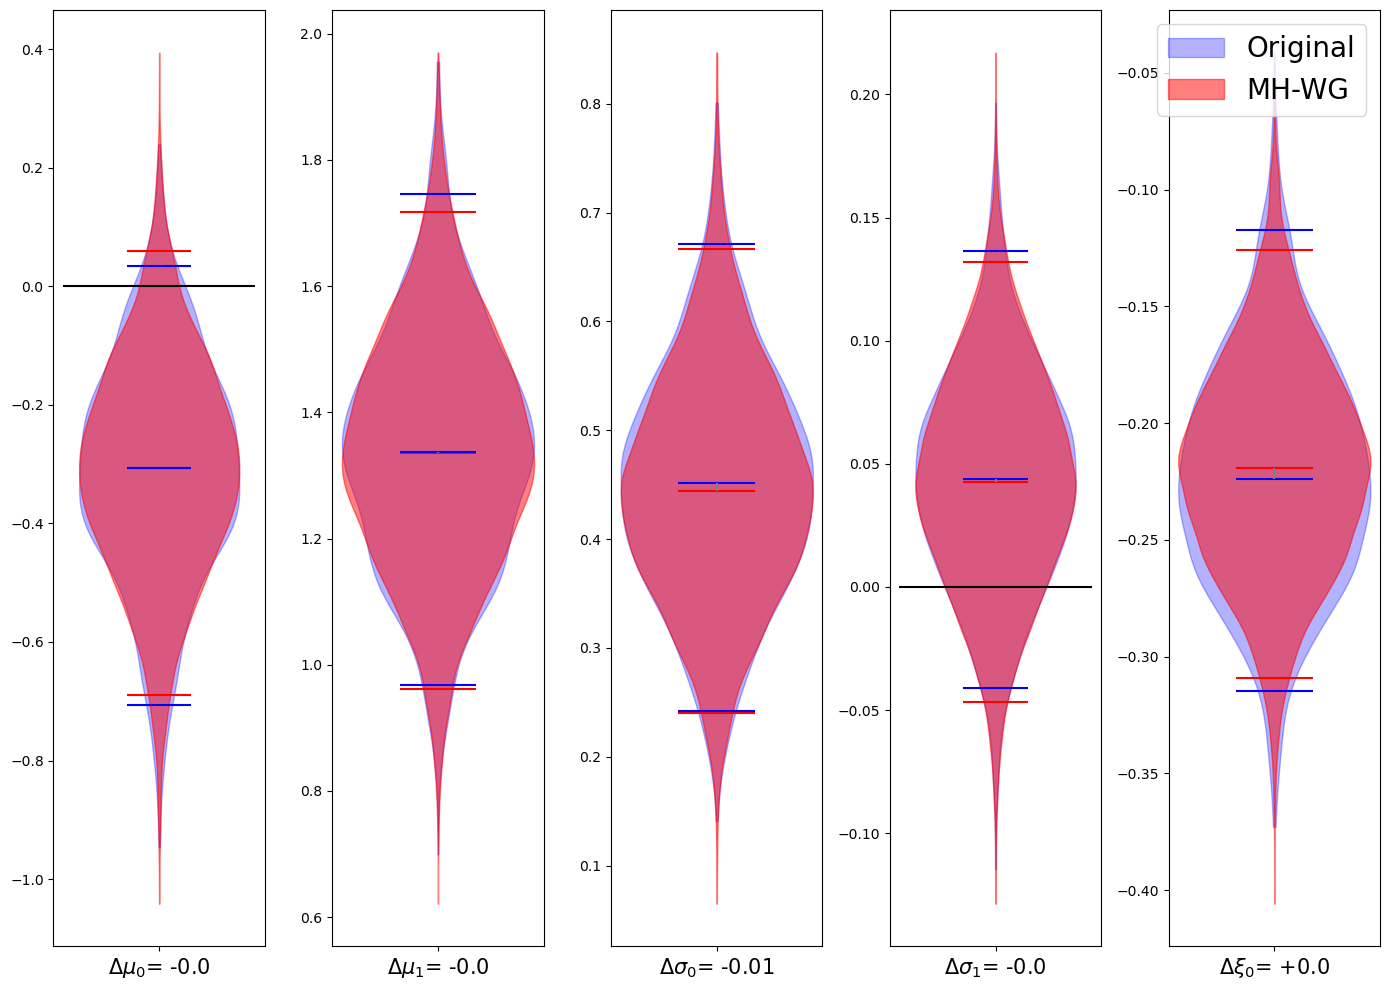

In [16]:
## Quantile
pathOut='Outputs/'
qcoef = clim_CXCB_Original.law_coef[:,1:,:].quantile( [ci/2,1-ci/2,0.5] , dim = "sample" ).assign_coords( quantile = ["ql","qu","BE"] )

qcoefX=clim_CXCB_MHWG.law_coef[:,1:,:].quantile( [ci/2,1-ci/2,0.5] , dim = "sample_MCMC" ).assign_coords( quantile = ["ql","qu","BE"] )
#if not clim.BE_is_median:
# qcoef.loc["BE",:,:] = clim.law_coef.loc[:,"BE",:]
#qcoef.loc[["ql","qu"],:,:] = qcoef.loc[["ql","qu"],:,:]
## mpl parameter


kwargs = {  "showmeans" : False , "showextrema" : False , "showmedians" : False }
#"positions" : range(clim.n_coef) ,
m='Multi_Synthesis'

fig = plt.figure( figsize = ( 14 , 10 ) )

for i in range(clim.n_coef):

    ax = fig.add_subplot(1,5,i+1)

    ## violin plot
    vplot = ax.violinplot( ((clim_CXCB_Original.law_coef) )[:,1:,:].loc[clim_CXCB_Original.law_coef.coef[i],:,m] , **kwargs )
    vplotc = ax.violinplot( ((clim_CXCB_MHWG.law_coef) )[:,1:,:].loc[clim_CXCB_MHWG.law_coef.coef[i],:,m]  , **kwargs )
    
    for pc in vplotc["bodies"]:
        pc.set_facecolor("red")
        pc.set_edgecolor("red")
        pc.set_alpha(0.5)

    for pc in vplot["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")
        pc.set_alpha(0.3)
    
    ## Change color
    #for pc in vplot["bodies"]:
    #    pc.set_facecolor("red")
    #    pc.set_edgecolor("red")
    #    pc.set_alpha(0.5)

    ## add quantiles

    for q in ["ql","qu","BE"]:
        a=ax.hlines( qcoefX[:,i,:].loc[q,m] , 1 - 0.1 , 1 + 0.1 , color = "red", label= "posterior" )
        ax.hlines( qcoef[:,i,:].loc[q,m] , 1 - 0.1 , 1 + 0.1 , color = "blue",label="prior" )
      
    #ax.hlines( 0 , -0.5 , clim.n_coef-0.5 , color = "black" )

    ax.vlines( 1 , qcoefX[:,i,:].loc["BE",m] , qcoef[:,i,:].loc["BE",m] , color = "grey" )

    ## some params
#ax.set_xlim((-0.5,clim.n_coef-0.5))
    ax.set_xticks([1])
    q=qcoefX[:,i,:].loc["BE",m] - qcoef[:,i,:].loc["BE",m] 
    xticks = [ "$\\Delta${}".format(clim.ns_law.get_params_names(True)[i]) + "= {}".format( "+" if np.sign(q) > 0 else "-" ) + r"${}$".format(float(np.sign(q)) * round(float(q),2)) ]
    ax.set_xticklabels( xticks , fontsize = 15 )
    if ((clim_CXCB_Original.law_coef) )[:,1:,:].loc[clim_CXCB_Original.law_coef.coef[i],:,m].min()*((clim_CXCB_Original.law_coef) )[:,1:,:].loc[clim_CXCB_Original.law_coef.coef[i],:,m].max()<0:
            ax.hlines( 0 , 1-0.3 , 1+0.3, color = "black" )
#for item in ax.get_yticklabels():
        #item.set_fontsize(15)
#ax.set_ylim(ylim)

#ax.set_title( " ".join(m.split("_")) , fontsize = 20 )
ax.legend(["Original","MH-WG"],fontsize = 20)
fig.set_tight_layout(True)

plt.savefig(os.path.join( pathOut ,"Distribution_parameters_PostBayes_MCMC_Original.png"))
plt.show()